<a href="https://colab.research.google.com/github/Yongjin-L/NLP/blob/main/Word2Vec_studentReflection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Word2Vec Model Development

In [ ]:
import pandas as pd

# Define the path to your CSV file
# Make sure this path exactly matches where you saved your CSV
csv_path = '/content/drive/My Drive/Data/Word2Vec/Word2Vec_Student_Reflection.csv'

try:
    df = pd.read_csv(csv_path)
    print("Data loaded successfully!")
    print(df.head()) # Display the first few rows to check
    print(f"Total entries: {len(df)}")
except FileNotFoundError:
    print(f"Error: The file was not found at {csv_path}")
    print("Please check the path and ensure the file is saved in your Google Drive.")
    print("You might need to download the Google Sheet as CSV and upload it to your specified folder first.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully!
   ID                                               text
0   1  i relearned about mind-body, competitive sport...
1   2  what do you like about people and the mind-bod...
2   3  I learned a lot about being patient and learni...
3   4  In this class I learned how people experience ...
4   5  i learned today people’s different reasons for...
Total entries: 977


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download necessary NLTK data (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download punkt_tab resource

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    words = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 1] # Remove single chars too
    return words

# Apply preprocessing to your 'text' column
df['processed_text'] = df['text'].apply(preprocess_text)

# Display some processed text examples
print("\nProcessed Text Examples:")
for i in range(5):
    if i < len(df):
        print(f"Original: {df['text'].iloc[i]}")
        print(f"Processed: {df['processed_text'].iloc[i]}\n")

# The list of lists of words is what Word2Vec expects
sentences = df['processed_text'].tolist()
print(f"Number of sentences (entries) for Word2Vec: {len(sentences)}")
print(f"Example of first processed sentence for Word2Vec: {sentences[0]}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Processed Text Examples:
Original: i relearned about mind-body, competitive sport, cultural, and physical activity and how each one is used in a varity of ways for each person
Processed: ['relearned', 'mindbody', 'competitive', 'sport', 'cultural', 'physical', 'activity', 'one', 'used', 'varity', 'way', 'person']

Original: what do you like about people and the mind-body is true stories and how we can relate to the mind, body practices, physical exercise practices culture, awareness, and activity. then, after reading other stories, we made our own stories to relate, including a graph.
Processed: ['like', 'people', 'mindbody', 'true', 'story', 'relate', 'mind', 'body', 'practice', 'physical', 'exercise', 'practice', 'culture', 'awareness', 'activity', 'reading', 'story', 'made', 'story', 'relate', 'including', 'graph']

Original: I learned a lot about being patient and learning that others have different styles of learning and some people are more competitive than others so that means 

In [ ]:
# Install gensim library
!pip install gensim numpy

In [ ]:
from gensim.models import Word2Vec
import multiprocessing # For setting up workers

# Model parameters
vector_size = 100    # Dimension of the word vectors
window = 7          # Context window size (how many words before and after to consider)
min_count = 5       # Ignores all words with total frequency lower than this
sg = 1              # 0 for CBOW (default), 1 for Skip-gram. Skip-gram is often better for smaller datasets.
workers = multiprocessing.cpu_count() # Use all available CPU cores

print(f"Training Word2Vec model with vector_size={vector_size}, window={window}, min_count={min_count}, sg={sg}, workers={workers}")

# Train the model
model = Word2Vec(sentences,
                 vector_size=vector_size,
                 window=window,
                 min_count=min_count,
                 sg=sg,
                 workers=workers)

# Build vocabulary
model.build_vocab(sentences)

# Train the model (can be iterative)
model.train(sentences, total_examples=model.corpus_count, epochs=10) # epochs can be adjusted

print("\nWord2Vec model training complete!")
print(f"Vocabulary size: {len(model.wv.index_to_key)}")

Training Word2Vec model with vector_size=100, window=7, min_count=5, sg=1, workers=2



Word2Vec model training complete!
Vocabulary size: 685


In [ ]:
# Get the vector for a specific word
word = "learning"
if word in model.wv:
    print(f"\nVector for '{word}':\n", model.wv[word][:10]) # Print first 10 dimensions
else:
    print(f"'{word}' not in vocabulary (min_count might be too high or word not frequent enough).")

# Find most similar words
print(f"\nWords most similar to 'learning':")
try:
    similar_words = model.wv.most_similar('learning')
    for word, score in similar_words:
        print(f"- {word}: {score:.4f}")
except KeyError:
    print("Word 'learning' not in vocabulary. Try a different word.")

# Find words that are not related
print(f"\nWords that are least similar to 'learning':")
try:
    # This is not a direct function, but you can find words with low cosine similarity
    # Or simply words far apart in the vector space.
    # A common approach is to pick a random sample and find the least similar among them.
    # For now, let's just reverse sort similar words, which isn't truly 'least' but illustrates.
    # A more robust way would be to compute all similarities and find the lowest.
    all_words = model.wv.index_to_key
    target_vector = model.wv['learning']
    similarities = {w: model.wv.similarity('learning', w) for w in all_words if w != 'learning'}
    least_similar_words = sorted(similarities.items(), key=lambda item: item[1], reverse=False)[:10]
    for word, score in least_similar_words:
         print(f"- {word}: {score:.4f}")
except KeyError:
    print("Word 'learning' not in vocabulary.")


# Perform a simple analogy (e.g., "king" - "man" + "woman" = "queen")
# This might not work perfectly with your specific data as it needs specific relationships
print("\nAnalogy Example (concept - antonym + other_concept):")
try:
    result = model.wv.most_similar(positive=['challenge', 'effort'], negative=['easy'], topn=1)
    if result:
        print(f"challenge - easy + effort: {result[0][0]} (score: {result[0][1]:.4f})")
    else:
        print("Could not find analogy.")
except KeyError:
    print("Some words for analogy not in vocabulary.")
except Exception as e:
    print(f"An error occurred during analogy: {e}")


Vector for 'learning':
 [ 0.14499965 -0.16374889  0.03198047  0.07421794 -0.08175925 -0.22044505
 -0.12962878  0.28075168  0.04154168 -0.19231568]

Words most similar to 'learning':
- background: 0.8649
- quickly: 0.8589
- acclimate: 0.8578
- growth: 0.8469
- engaging: 0.8424
- style: 0.8407
- cooperation: 0.8406
- family: 0.8405
- similar: 0.8397
- share: 0.8339

Words that are least similar to 'learning':
- volleyball: 0.1877
- basketball: 0.2072
- calm: 0.2871
- stress: 0.2879
- mind: 0.3121
- mindbody: 0.3124
- practice: 0.3143
- pose: 0.3180
- walk: 0.3219
- mental: 0.3270

Analogy Example (concept - antonym + other_concept):
challenge - easy + effort: push (score: 0.9121)


In [ ]:
import os

# Define the path to save the model
model_save_path = '/content/drive/My Drive/Data/Word2Vec/word2vec_model_window7vector100.bin'
model_save_dir = os.path.dirname(model_save_path)

# Create the directory if it doesn't exist
os.makedirs(model_save_dir, exist_ok=True)

# Save the model
model.save(model_save_path)
print(f"\nWord2Vec model saved to: {model_save_path}")

# To load the model later:
# loaded_model = Word2Vec.load(model_save_path)
# print(f"Model loaded from {model_save_path}. Vocabulary size: {len(loaded_model.wv.index_to_key)}")


Word2Vec model saved to: /content/drive/My Drive/Data/Word2Vec/word2vec_model_window7vector100.bin


## Visualization 1: T-SNE

Loading Word2Vec model from: /content/drive/My Drive/Data/Word2Vec/word2vec_model_window7vector100.bin
Model loaded successfully!
Vocabulary size: 685

Preparing 500 words for t-SNE visualization...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE dimensionality reduction complete.


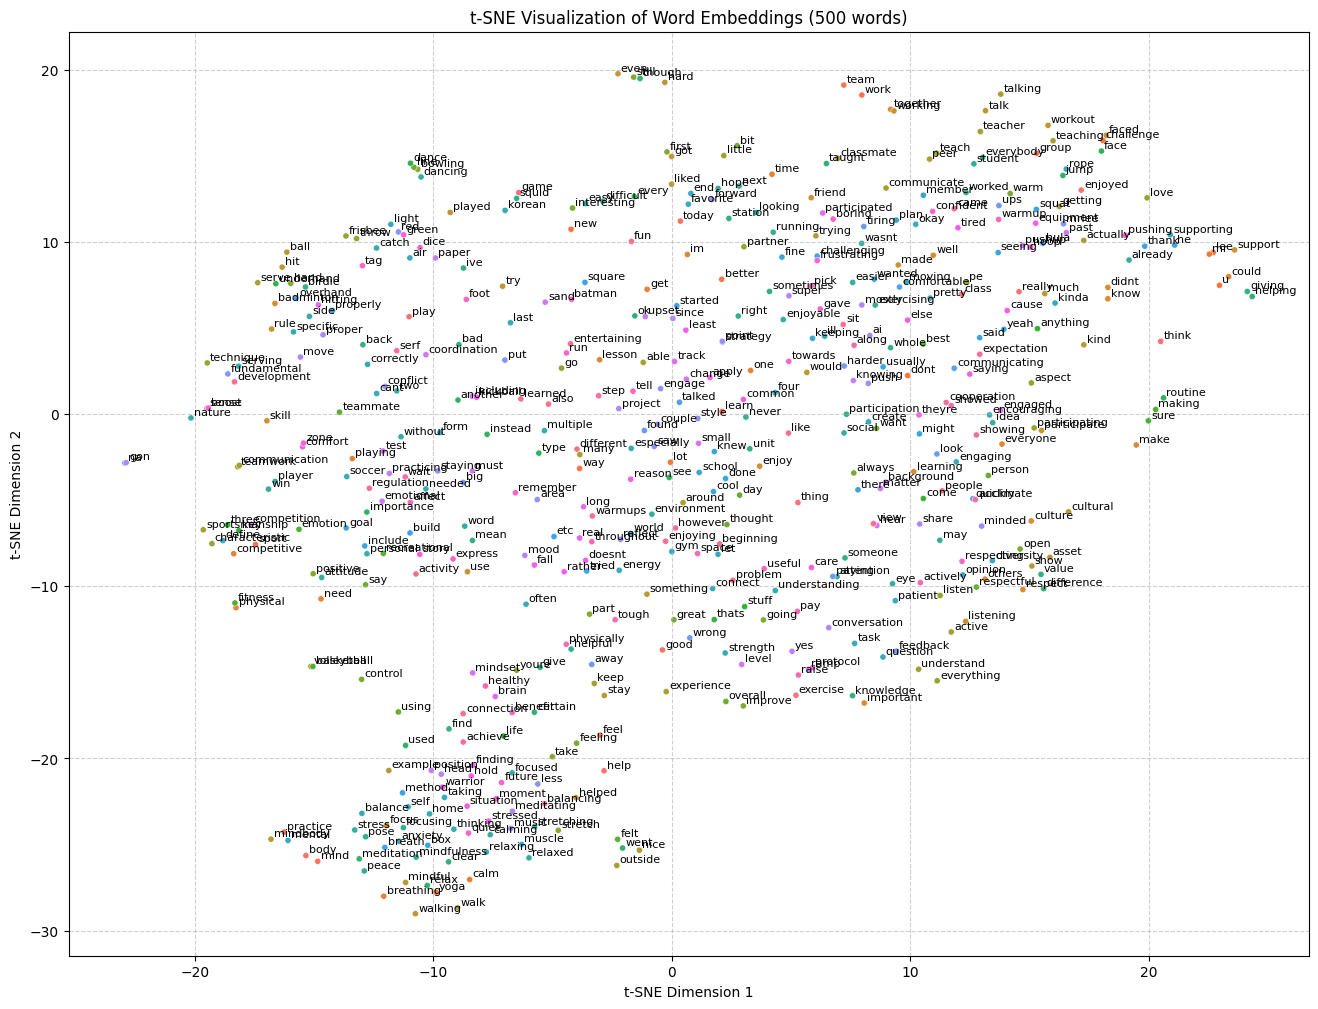


Visualization complete. Look for clusters of words that appear together.
These clusters represent words that are semantically similar based on their usage in your student reflections.
You might need to zoom in or adjust 'num_words_to_visualize' for better clarity.


In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np # Import numpy

# --- Step 1: Load the trained Word2Vec model ---
model_load_path = '/content/drive/My Drive/Data/Word2Vec/word2vec_model_window7vector100.bin'

if not os.path.exists(model_load_path):
    print(f"Error: Model file not found at {model_load_path}")
    print("Please ensure the path is correct and the model was saved successfully.")
else:
    print(f"Loading Word2Vec model from: {model_load_path}")
    model = Word2Vec.load(model_load_path)
    print("Model loaded successfully!")
    print(f"Vocabulary size: {len(model.wv.index_to_key)}")

    # --- Step 2: Prepare data for t-SNE ---
    # We'll take a subset of words for visualization, as plotting all can be messy
    # You might want to experiment with different filtering methods (e.g., top N most frequent words)
    # For now, let's just take the first N words in the vocabulary
    num_words_to_visualize = 500 # Adjust this number based on your vocabulary size and desired density
    words = []
    embeddings = []

    # Get words and their vectors from the model's vocabulary
    for i, word in enumerate(model.wv.index_to_key):
        if i >= num_words_to_visualize:
            break
        words.append(word)
        embeddings.append(model.wv[word])

    print(f"\nPreparing {len(words)} words for t-SNE visualization...")

    # Convert the list of embeddings to a NumPy array
    embeddings_array = np.array(embeddings)


    # --- Step 3: Apply t-SNE for dimensionality reduction ---
    # perplexity: related to the number of nearest neighbors that is used in other manifold learning algorithms.
    # It balances attention between local and global aspects of your data. (common values: 5-50)
    # n_iter: maximum number of iterations for the optimization.
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=2500)
    reduced_embeddings = tsne.fit_transform(embeddings_array) # Use the NumPy array here

    print("t-SNE dimensionality reduction complete.")

    # --- Step 4: Create a DataFrame for plotting ---
    df_tsne = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
    df_tsne['word'] = words

    # --- Step 5: Plot the embeddings ---
    plt.figure(figsize=(16, 12))
    sns.scatterplot(x='x', y='y', data=df_tsne, hue='word', legend=False, s=20)

    # Add word annotations for better interpretability
    # This can make the plot very crowded if num_words_to_visualize is too high
    for i, row in df_tsne.iterrows():
        plt.annotate(row['word'], (row['x'], row['y']), textcoords="offset points", xytext=(2,2), ha='left', fontsize=8)

    plt.title(f't-SNE Visualization of Word Embeddings ({len(words)} words)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    print("\nVisualization complete. Look for clusters of words that appear together.")
    print("These clusters represent words that are semantically similar based on their usage in your student reflections.")
    print("You might need to zoom in or adjust 'num_words_to_visualize' for better clarity.")

## Visualization 2: UMAP

In [ ]:
!pip install umap-learn

Loading Word2Vec model from: /content/drive/My Drive/Data/Word2Vec/word2vec_model_window7vector100.bin
Model loaded successfully!
Vocabulary size: 685

Preparing 200 words for UMAP visualization...
UMAP dimensionality reduction complete.


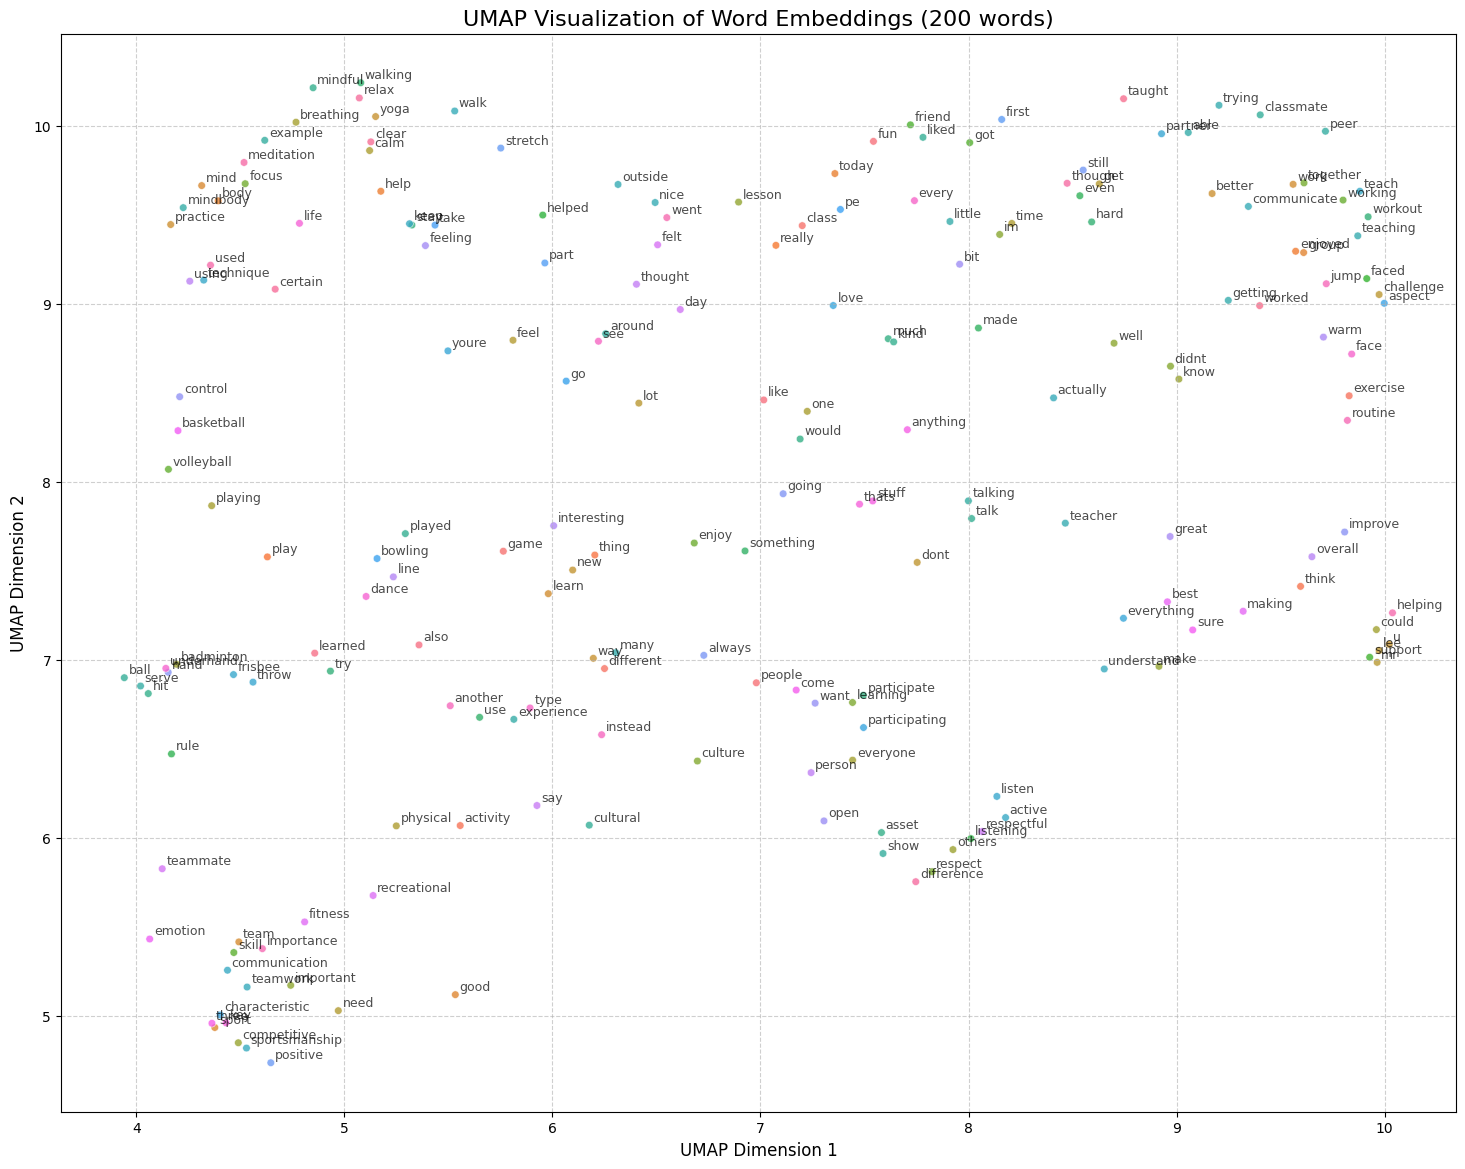


UMAP visualization complete. Observe the clusters and overall structure.
Words that are close together are semantically similar in your student reflection data.
Experiment with `n_neighbors`, `min_dist`, and `num_words_to_visualize` for different views.


In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import umap.umap_ as umap # Import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Step 1: Load the trained Word2Vec model ---
model_load_path = '/content/drive/My Drive/Data/Word2Vec/word2vec_model_window7vector100.bin'

if not os.path.exists(model_load_path):
    print(f"Error: Model file not found at {model_load_path}")
    print("Please ensure the path is correct and the model was saved successfully.")
else:
    print(f"Loading Word2Vec model from: {model_load_path}")
    model = Word2Vec.load(model_load_path)
    print("Model loaded successfully!")
    print(f"Vocabulary size: {len(model.wv.index_to_key)}")

    # --- Step 2: Prepare data for UMAP ---
    num_words_to_visualize = 200 # You can adjust this. Try 200, 500, 1000. # Too many words will make the plot unreadable.
    words = []
    embeddings = []

    # Get words and their vectors from the model's vocabulary
    # You might want to filter by frequency if you have many rare words
    for i, word in enumerate(model.wv.index_to_key):
        if i >= num_words_to_visualize:
            break
        words.append(word)
        embeddings.append(model.wv[word])

    print(f"\nPreparing {len(words)} words for UMAP visualization...")

    # --- Step 3: Apply UMAP for dimensionality reduction ---
    # UMAP parameters:
    # n_components: The dimension of the space to embed into (2 for 2D plot)
    # n_neighbors: Controls how UMAP balances local vs. global structure.
    #              Smaller values (e.g., 5-10) emphasize local clustering.
    #              Larger values (e.g., 15-50 or more) preserve more global structure.
    # min_dist: Controls how tightly points are packed together.
    #           Smaller values (e.g., 0.0) allow tighter packing (dense clusters).
    #           Larger values (e.g., 0.5) spread points out more evenly.
    # metric: The distance metric to use (e.g., 'cosine' for word embeddings).
    # random_state: For reproducibility.

    reducer = umap.UMAP(n_components=2,
                        n_neighbors=15, # Common range: 5 to 50
                        min_dist=0.1,  # Common range: 0.0 to 0.5
                        metric='cosine', # 'euclidean' is default, 'cosine' often better for embeddings
                        random_state=42)

    reduced_embeddings = reducer.fit_transform(embeddings)

    print("UMAP dimensionality reduction complete.")

    # --- Step 4: Create a DataFrame for plotting ---
    df_umap = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
    df_umap['word'] = words

    # --- Step 5: Plot the embeddings ---
    plt.figure(figsize=(18, 14)) # Slightly larger figure size for better readability
    sns.scatterplot(x='x', y='y', data=df_umap, hue='word', legend=False, s=30, alpha=0.8) # Adjust dot size

    # Add word annotations
    # This loop can make the plot very crowded if num_words_to_visualize is high.
    # Consider only annotating a subset of words, or only specific words of interest.
    for i, row in df_umap.iterrows():
        plt.annotate(row['word'], (row['x'], row['y']), textcoords="offset points", xytext=(3,3), ha='left', fontsize=9, alpha=0.7)

    plt.title(f'UMAP Visualization of Word Embeddings ({len(words)} words)', fontsize=16)
    plt.xlabel('UMAP Dimension 1', fontsize=12)
    plt.ylabel('UMAP Dimension 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    print("\nUMAP visualization complete. Observe the clusters and overall structure.")
    print("Words that are close together are semantically similar in your student reflection data.")
    print("Experiment with `n_neighbors`, `min_dist`, and `num_words_to_visualize` for different views.")

## K-Means Clustering

Loading Word2Vec model from: /content/drive/My Drive/Data/Word2Vec/word2vec_model_window7vector100.bin
Model loaded successfully!
Vocabulary size: 685

Extracted 685 word embeddings for clustering.
Embeddings scaled.

Running Elbow Method to find optimal 'k'...


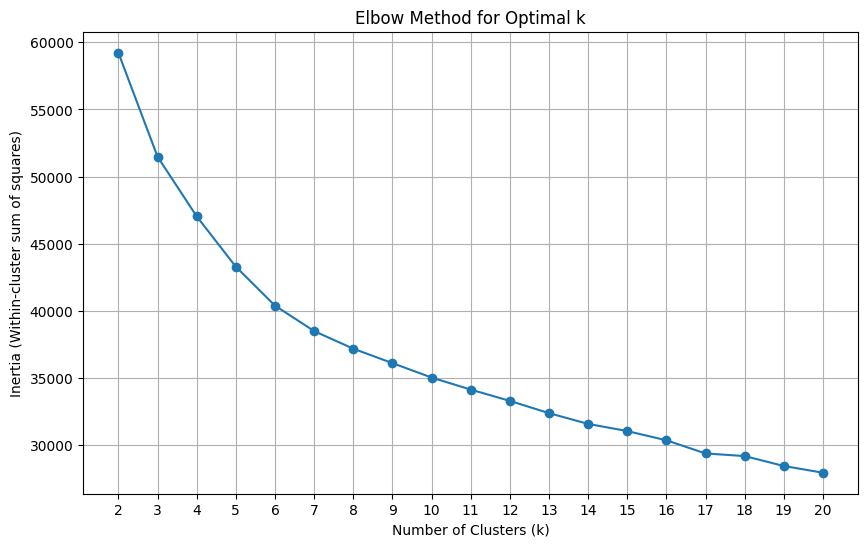


Elbow Method plot displayed. Look for the 'elbow' point where the decrease in inertia starts to slow down significantly.
Choose a 'k' value based on this visual inspection.

Proceeding with K-Means clustering with k = 5 clusters.
Clustering complete. Assigned 685 words to 5 clusters.

--- Top 20 words per cluster: ---

Cluster 0: (Total words: 67)
people, different, activity, thing, way, new, everyone, others, culture, learning, respect, enjoy, listening, use, participate, asset, cultural, show, many, active

Cluster 1: (Total words: 129)
help, body, mind, practice, yoga, feel, calm, breathing, focus, helped, something, walking, stay, mindful, example, mindbody, experience, nice, outside, walk

Cluster 2: (Total words: 96)
learned, also, game, play, playing, badminton, volleyball, got, rule, try, hit, played, ball, serve, frisbee, throw, go, bowling, first, hand

Cluster 3: (Total words: 70)
sport, team, need, physical, competitive, important, skill, teamwork, sportsmanship, communica

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # Important for K-Means with embeddings
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Step 1: Load the trained Word2Vec model ---
model_load_path = '/content/drive/My Drive/Data/Word2Vec/word2vec_model_window7vector100.bin'

if not os.path.exists(model_load_path):
    print(f"Error: Model file not found at {model_load_path}")
    print("Please ensure the path is correct and the model was saved successfully.")
    exit() # Exit if model not found
else:
    print(f"Loading Word2Vec model from: {model_load_path}")
    model = Word2Vec.load(model_load_path)
    print("Model loaded successfully!")
    print(f"Vocabulary size: {len(model.wv.index_to_key)}")

# --- Extract words and their embeddings ---
# We'll use all words in the vocabulary for clustering
# You might want to filter for most frequent words if your vocabulary is huge or has many rare words
words = model.wv.index_to_key
embeddings = model.wv[words]

print(f"\nExtracted {len(words)} word embeddings for clustering.")

# --- Preprocessing for K-Means (Scaling) ---
# It's good practice to scale features for K-Means as it's distance-based.
# Word embeddings are often already somewhat normalized, but scaling won't hurt.
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)
print("Embeddings scaled.")

# --- Step 2: Determine Optimal k using the Elbow Method ---
# This can be computationally intensive for many words/clusters.
# We'll test a range of possible cluster numbers.
max_clusters = 20 # You can adjust this max value.
inertias = []
k_range = range(2, max_clusters + 1) # Start from 2 clusters

print("\nRunning Elbow Method to find optimal 'k'...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init for robustness
    kmeans.fit(scaled_embeddings)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

print("\nElbow Method plot displayed. Look for the 'elbow' point where the decrease in inertia starts to slow down significantly.")
print("Choose a 'k' value based on this visual inspection.")

# --- Step 3: Perform K-Means Clustering with your chosen k ---
# IMPORTANT: After looking at the plot, manually set your chosen_k here.
# For demonstration, let's pick an arbitrary number, but you should choose based on the plot.
chosen_k = 5 # <--- REPLACE THIS WITH THE 'k' YOU CHOOSE FROM THE ELBOW PLOT!
print(f"\nProceeding with K-Means clustering with k = {chosen_k} clusters.")

kmeans_model = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(scaled_embeddings)

# Create a DataFrame to store words and their cluster labels
df_clusters = pd.DataFrame({'word': words, 'cluster': cluster_labels})

print(f"Clustering complete. Assigned {len(df_clusters)} words to {chosen_k} clusters.")

# --- Step 4: Analyze Clusters ---
# Display the top N most frequent words in each cluster to interpret topics
words_per_cluster_to_display = 20 # Adjust how many words to show per cluster

print(f"\n--- Top {words_per_cluster_to_display} words per cluster: ---")
for cluster_id in range(chosen_k):
    cluster_words = df_clusters[df_clusters['cluster'] == cluster_id]['word'].tolist()

    # Optional: To get a better sense, you might want to show the most central words,
    # but for simplicity, we'll just show the first N words that fall into that cluster.
    # For more meaningful display, you could sort by proximity to centroid or overall frequency.

    print(f"\nCluster {cluster_id}: (Total words: {len(cluster_words)})")
    print(", ".join(cluster_words[:words_per_cluster_to_display]))

    # If you want to save each cluster's words to a file:
    # with open(f'/content/drive/My Drive/Data/Word2Vec/cluster_{cluster_id}_words.txt', 'w') as f:
    #     for word in cluster_words:
    #         f.write(word + '\n')

print("\nClustering analysis complete. Manually inspect the word lists for each cluster to infer the underlying topics.")
print("You might need to re-run with a different 'chosen_k' if the topics aren't coherent.")